In [63]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Import modules and necessary core and helper functions

In [64]:
import os
import sys
sys.path.insert(0,'/home/meyerann/WPG')

import time
import copy
import numpy
import pylab

#Base wavefront class
from wpg import Wavefront

from wpg.srwlib import srwl, SRWLOptD, SRWLOptL, SRWLOptC, SRWLOptA, SRWLOptMirEl
#Gaussian beam generator
from wpg.generators import build_gauss_wavefront_xy
#helper functions
#from wfrutilsAKM import plot_wfront
from wpg.useful_code.wfrutils import plot_wfront, get_mesh,print_beamline,calculate_fwhm_y

pylab.ion()

In [65]:
def calculate_theta_fwhm_cdr(ekev,qnC):
    """
    Calculate angular divergence using formula from XFEL CDR2011
    
    :param ekev: Energy in keV
    :param qnC: e-bunch charge, [nC]
    :return: theta_fwhm [units?]
    """
    theta_fwhm = (17.2 - 6.4 * sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

In [66]:
def defineEFM(orient,p,q,thetaEFM,theta0,lengthEFM):
    """
    A wrapper to a SRWL function SRWLOptMirEl() for defining a plane elliptical focusing mirror propagator
    
    :param Orient:    mirror orientation, 'x' (horizontal) or 'y' (vertical)
    :param p:  the distance to two ellipsis centers
    :param q:  the distance to two ellipsis centers
    :param thetaEFM:  the design incidence angle in the center of the mirror
    :param theta0:    the "real" incidence angle in the center of the mirror
    :param lengthEFM: mirror length, [m]
    :return: the struct opEFM
    """
    if orient == 'x':     #horizontal plane ellipsoidal mirror
        opEFM = SRWLOptMirEl(_p=p, _q=q, _ang_graz=thetaEFM, _r_sag=1.e+40, _size_tang=lengthEFM, 
            _nvx=cos(theta0), _nvy=0, _nvz=-sin(theta0), _tvx=-sin(theta0), _tvy=0, _x=0, _y=0, _treat_in_out=1) 
    elif orient == 'y': #vertical plane ellipsoidal mirror
        opEFM = SRWLOptMirEl(_p=p, _q=q, _ang_graz=thetaEFM, _r_sag=1.e+40, _size_tang=lengthEFM, 
            _nvx=0, _nvy=cos(theta0), _nvz=-sin(theta0), _tvx=0, _tvy=-sin(theta0), _x=0, _y=0, _treat_in_out=1)
    else:
        raise TypeError('orient should be "x" or "y"')
    return opEFM

#### 1. Define Gaussian wavefront parameters and build it.

${\omega}_0$: beam waist

$\lambda=\frac{12.4}{E[kev]}$: wave length of beam

$\theta = \frac{\lambda}{\pi\omega_0}$ --> $\omega_0 = \frac{\lambda}{\pi\theta}$

${z}_R=\frac{\pi{\omega_0}^2}{\lambda}$ Rayleigh length/range. At this point the beam is widened to $\sqrt{2}\omega_0$

Comparison of the intensity of the wavefront and normal distribution

$\frac{1}{2} = exp(-\frac{r^2}{2\sigma^2}) = exp(-\frac{2r^2}{\omega(z)^2})$

$\frac{r^2}{2\sigma^2} = \frac{2r^2}{\omega(z)^2}$

$\frac{1}{2\sigma^2} = \frac{2}{\omega(z)^2}$

$\frac{\omega(z)^2}{2} = 2\sigma^2$

$\frac{\omega(z)^2}{4} = \sigma^2$ ; $\omega(z=0)^2 = \omega_0^2$

beam radius at several point

$\omega(z) = \omega_0*\sqrt{1+(\frac{z}{z_0})^2}$

FWHM of intensity

$\frac{1}{2} = exp(-\frac{2x^2}{w^2})$
-->
$2x = w\sqrt{ln2*2}$ --> $2x = 2*\sigma\sqrt{ln2*2}$ --> $x = \sigma\sqrt{ln2*2}$



FWHM of amplitude

$\frac{1}{2} = exp(-\frac{x^2}{w^2})$
-->
$x = w\sqrt{-ln\frac{1}{2}}$ --> $x = 2*\sigma\sqrt{ln2}$


Focal length for thin lenses

$\frac{1}{f}=\frac{1}{p}+\frac{1}{q}$

### Define Gaussian wavefront parameters and build it.

theta_fwhm [urad]: 18.3457259238
w0 [nm]: 26.8934751142
lamda [nm]: 1.55
2*z0 [nm]: 2.93185183578
sigma_Intensity []: 1.61511778049e-05
expected FWHM at distance 300.0: 5.50 mm
FWHMx [mm]: 5.31066827322
FWHMy [mm]: 5.31066827322
Coordinates of center, [mm]: 0.034484858917 0.034484858917
stepX, stepY [um]: 68.9697178341 68.9697178341 

 
vertical FWHM at distance 300.0: 5.311 mm
 total length: 300.0


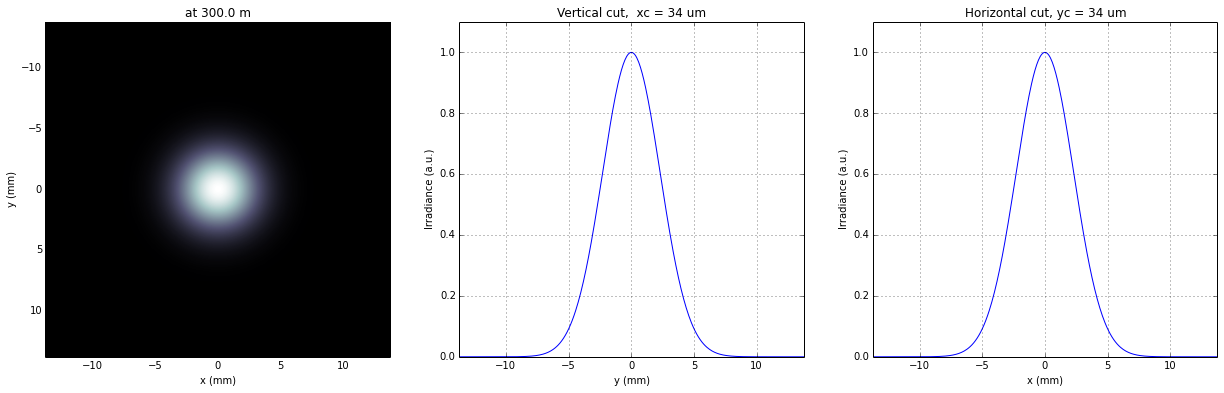

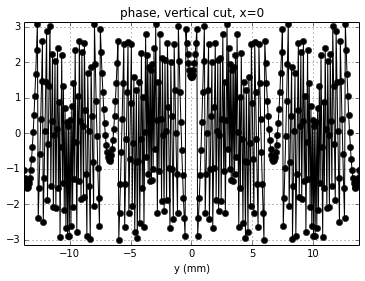

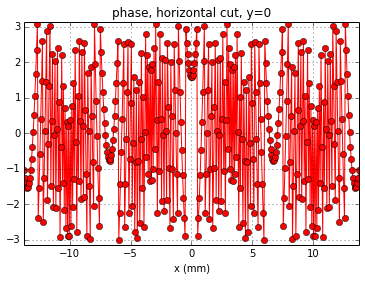

In [67]:
#wavefront parameters
qnC = 0.1                    # e-bunch charge, [nC]
pulse_duration = 9.e-15      # [s]      
ekev = 0.8            # Energy in [keV]
#number of points
np = 400
d2VLens = 300.0
lamda = 12.4*1e-10/ekev # wavelength [AKM]
#calculate angular divergence
theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)
#calculate rayleigh range z
w0 = lamda/(pi*theta_fwhm) # beam waist
#calculate angular divergence by calculating sigma of amplitude
sigmaAmp = w0/(2*sqrt(log(2)))
#calculate Rayleigh length
z0 = (pi*w0**2)/lamda

#quintuple beam radius at horizontal lens distance to get the range of the wavefront 
range_xy = w0*sqrt(1+(d2VLens/z0)**2) *5
print 'theta_fwhm [urad]:', theta_fwhm*1e6
print 'w0 [nm]:', w0*1e6
print 'lamda [nm]:', lamda*1e9
print '2*z0 [nm]:', 2*z0
print 'sigma_Intensity []:', sigmaAmp
print 'expected FWHM at distance %.1f: %.2f mm' %(d2VLens,theta_fwhm*d2VLens*1e3)


#build wavefront
wfr = build_gauss_wavefront_xy(nx=np, ny=np, ekev=ekev, xMin=-range_xy/2, xMax=range_xy/2, 
                               yMin=-range_xy/2, yMax=range_xy/2, sigX=sigmaAmp, 
                               sigY=sigmaAmp,d2waist=d2VLens)


#init WPG Wavefront helper class
mwf = Wavefront(wfr)

#defining name HDF5 file for storing wavefront
strOutputDataFolder = 'data_common'
wfr0Name = os.path.join(strOutputDataFolder,'gwf_AKM'+'.h5')
#store wavefront to HDF5 file 
mwf.store_hdf5(wfr0Name)


#plot the wavefront
plot_wfront(mwf, title_fig='at '+str(d2VLens)+' m', isHlog=False, isVlog=False,
            i_x_min=1e-5, i_y_min=1e-5, orient='x', onePlot=True, bPlotPha=True)
print ' '
print 'vertical FWHM at distance %.1f: %.3f mm' %(d2VLens,calculate_fwhm_y(mwf)*1e3)
print ' total length:', mwf.params.Mesh.zCoord

### Focusing with vertical cylindrical lens
Calculating expected beam size after propagation and
propagate wavefront from frist vertical lens at 300 m to calculated focus at 400 m.

In [68]:
verticalFocus = 400.0
q = verticalFocus-d2VLens
d2verticalFocus =1./(1./d2VLens + 1./q) #calculating horizontal focal length
thetaEM = 52.4e-3   # incidence angle of elliptical  mirror, 3 deg
lengthM = 0.5 #[m]

FWHM_1HFocus = q/d2VLens*calculate_fwhm_y(mwf)
print 'd2verticalFocus = %.1f m' %(q)
print 'horizontalFocus at distance %.1f m' %(d2verticalFocus+d2VLens)
print 'expected vertical FWHM at distance %.1f: %.2f mm' %(verticalFocus,FWHM_1HFocus*1e3)


d2verticalFocus = 100.0 m
horizontalFocus at distance 375.0 m
expected vertical FWHM at distance 400.0: 1.77 mm


Optical Element: Mirror: Ellipsoid
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 0
	Fy = 0
	angGraz = 0.0524
	apShape = r
	arRefl = array of size 2
	ds = 1
	dt = 0.5
	extIn = 0
	extOut = 0
	meth = 2
	nps = 500
	npt = 500
	nvx = 0
	nvy = 0.998627434104
	nvz = -0.0523760236546
	p = 300.0
	q = 100.0
	radSag = 1e+40
	reflAngFin = 0
	reflAngScaleType = lin
	reflAngStart = 0
	reflNumAng = 1
	reflNumComp = 1
	reflNumPhEn = 1
	reflPhEnFin = 1000.0
	reflPhEnScaleType = lin
	reflPhEnStart = 1000.0
	treatInOut = 1
	tvx = 0
	tvy = -0.0523760236546
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 1, 1.0, 1, 0, 2.0, 1.0, 2.0, 1.0, 0, 0, 0]
	L = 75.0
	treat = 0
	

FWHMx [mm]: 6.72636239301
FWHMy [mm]: 1.32062688917
Coordinates of center, [mm]: 0.0425719138798 0.00880417926113
stepX, stepY [um]: 85.1438277596 17.6083585223 

 
vertical FWHM at distance 375.0: 1.321 mm


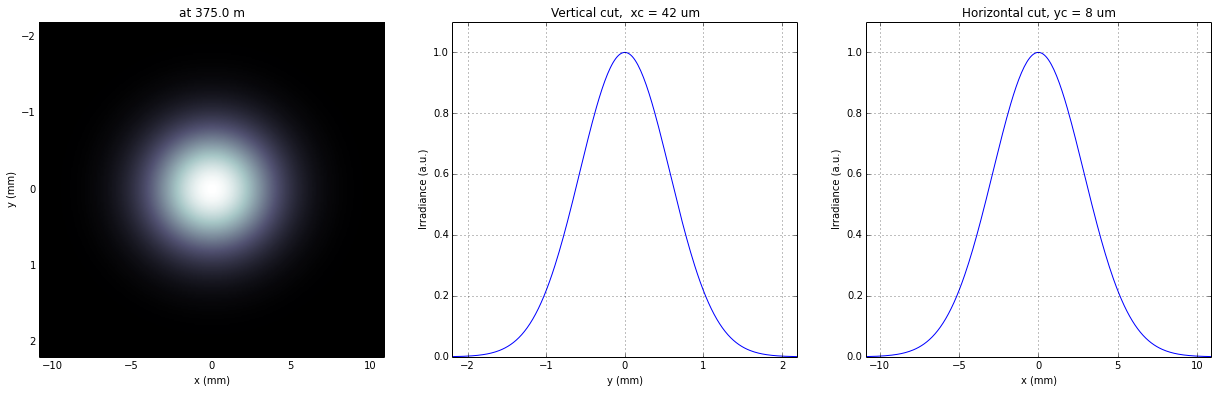

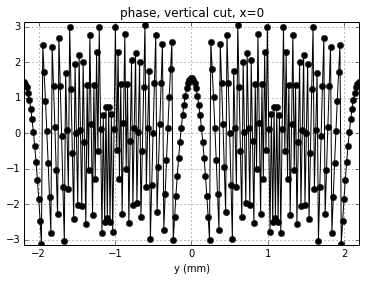

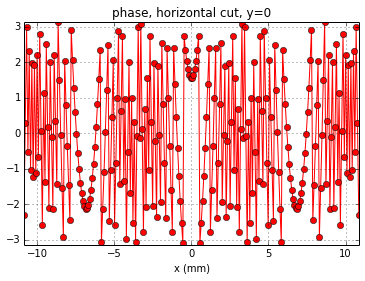

In [69]:
DriftvEFM_vFocus = SRWLOptD(d2verticalFocus)
verticalEFM = defineEFM(orient='y',p=d2VLens,q=q,thetaEFM=thetaEM,theta0=thetaEM,lengthEFM=lengthM)
#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#               [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11] 
ppDriftVL_foc = [ 0,  1, 1.0,  1,  0, 2.0, 1.0, 2.0, 1.0,  0,  0,   0]
ppVEFM =          [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

optBL0 = SRWLOptC([verticalEFM, DriftvEFM_vFocus],
                  [ppVEFM ,ppDriftVL_foc]) 
print_beamline(optBL0)

w2 = Wavefront()
w2.load_hdf5(wfr0Name)
wfr = w2._srwl_wf

srwl.PropagElecField(wfr, optBL0)
mwf = Wavefront(wfr)
mwf.store_hdf5(wfr0Name)
plot_wfront(mwf, title_fig='at '+str(d2verticalFocus+d2VLens)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='x', onePlot=True, bPlotPha=True)
print ' '
print 'vertical FWHM at distance %.1f: %.3f mm' %(d2verticalFocus+d2VLens,calculate_fwhm_y(mwf)*1e3)

### Focusing with second vertical lens as KB lens
Calculating expected beam size after propagation and
propagate wavefront from frist vertical focus at 400 m to focus of KB lens at 444 m.

In [70]:
#?????
d2VKB = 442.3 #[AKM] is it equal to HKB position?
p2 = d2VKB - verticalFocus
#???
dVKB_foc = 1.715  # nominal focal length for HFM KB
d1VL2VKB = d2VKB-d2verticalFocus-d2VLens
VKB_foc =  1. /(1./p2 + 1. / dVKB_foc) # for thin lens approx
FWHM_2VFocus = dVKB_foc/p2*calculate_fwhm_y(mwf)
print 'vertical KB focus: %.3f m' %(VKB_foc)
print 'p = d1HL2HKB [m]:', d1VL2VKB
print 'q/p :', dVKB_foc/d1VL2VKB
print 'expected vertical FWHM at distance %.1f: %.3f mm' %(d2VKB + dVKB_foc,FWHM_2VFocus*1e3)


vertical KB focus: 1.648 m
p = d1HL2HKB [m]: 67.3
q/p : 0.0254829123328
expected vertical FWHM at distance 444.0: 0.054 mm


Optical Element: Drift Space
Prop. parameters = [0, 1, 1.0, 1, 0, 2.0, 1.0, 2.0, 1.0, 0, 0, 0]
	L = 67.3
	treat = 0
	
Optical Element: Thin Lens
Prop. parameters = [0, 1, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1.715
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 1, 1.0, 1, 0, 2.0, 1.0, 2.0, 1.0, 0, 0, 0]
	L = 1.715
	treat = 0
	

FWHMx [mm]: 7.91435192151
FWHMy [mm]: 0.0918351985642
Coordinates of center, [mm]: -0.0500908349462 -0.0005045890031
stepX, stepY [um]: 100.181669892 1.0091780062 

 
vertical FWHM at distance 444.0: 0.092 mm
 total length: 300.0


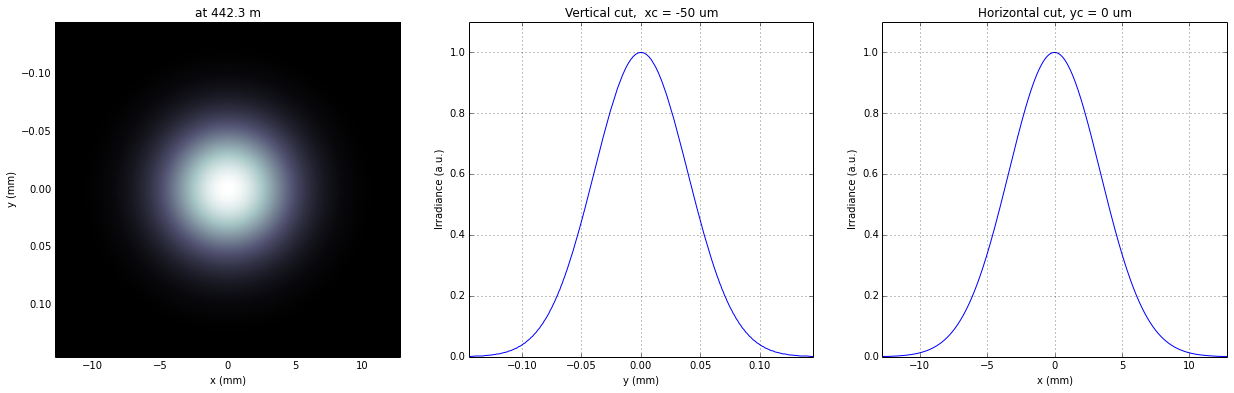

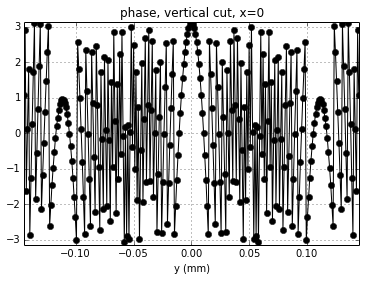

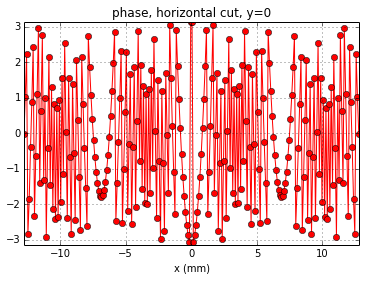

In [71]:
VKB = SRWLOptL(_Fy=dVKB_foc) #VKB as Thin Lens
#               [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11] 
ppVKB =         [ 0,  1, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDrift2VKB =   [ 0,  1, 1.0,  1,  0, 2.0, 1.0, 2.0, 1.0,  0,  0,   0]
ppDrift2Focus = [ 0,  1, 1.0,  1,  0, 2.0, 1.0, 2.0, 1.0,  0,  0,   0]

DriftHFocus1_VKB = SRWLOptD(d1VL2VKB)
Drift2Focus = SRWLOptD(dVKB_foc)
optBL1 = SRWLOptC([DriftHFocus1_VKB, VKB, Drift2Focus],
                  [ppDrift2VKB,ppVKB, ppDrift2Focus]) 
print_beamline(optBL1)

w2.load_hdf5(wfr0Name)
wfr = w2._srwl_wf

srwl.PropagElecField(wfr, optBL1)
mwf = Wavefront(wfr)
#mwf.store_hdf5(wfr0Name)
plot_wfront(mwf, title_fig='at '+str(d2VKB)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='y', onePlot=True, bPlotPha=True)
print ' '
print 'vertical FWHM at distance %.1f: %.3f mm' %(d2VKB + dVKB_foc,calculate_fwhm_y(mwf)*1e3)
print ' total length:', mwf.params.Mesh.zCoord

### Plot wavefront out of focus at rayleigh length
Propagate the beamline further to distance of rayleigh length at 446m

z0 [nm] : 1.46592591789
Optical Element: Drift Space
Prop. parameters = [0, 1, 1.0, 1, 0, 2.0, 1.0, 2.0, 1.0, 0, 0, 0]
	L = 1.46592591789e-09
	treat = 0
	

FWHMx [mm]: 6.72636239303
FWHMy [mm]: 1.3206268891
Coordinates of center, [mm]: 0.04257191388 0.00880417926067
stepX, stepY [um]: 85.1438277599 17.6083585213 

 
vertical FWHM at distance 444.0: 1.321 mm
 total length: 300.0


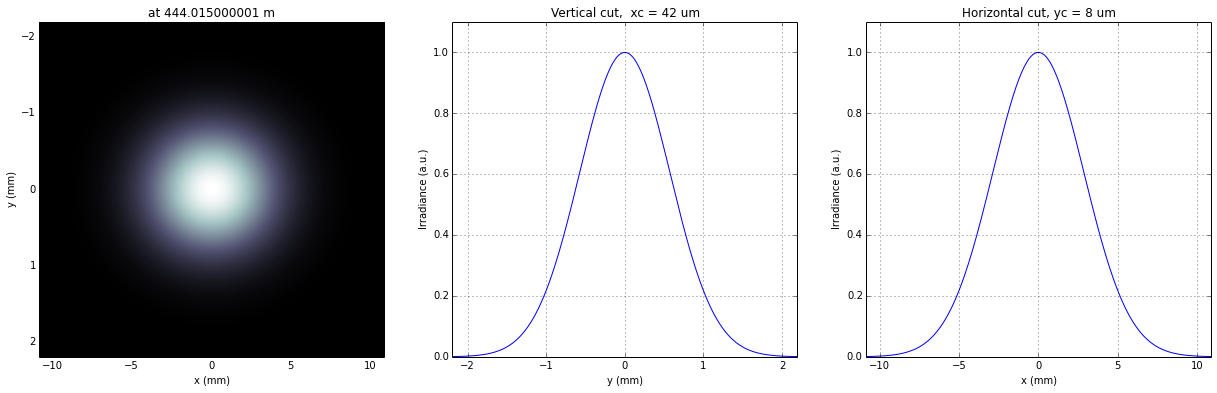

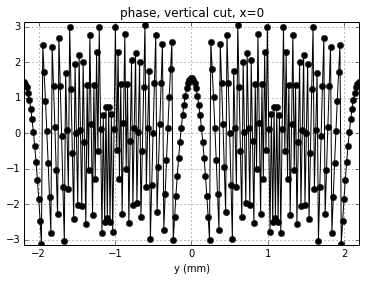

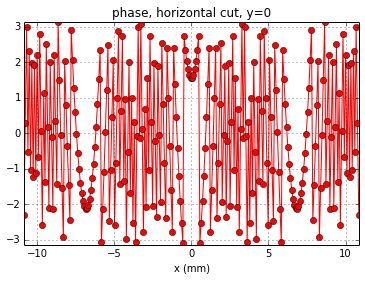

In [72]:
DriftOutOfFocus= SRWLOptD(z0*1e-9)
print 'z0 [nm] :', z0

ppDriftOutOfFocus = [ 0,  1, 1.0,  1,  0, 2.0, 1.0, 2.0, 1.0,  0,  0,   0]
optBL2 = SRWLOptC([DriftOutOfFocus],
                  [ppDriftOutOfFocus]) 
print_beamline(optBL2)

w2.load_hdf5(wfr0Name)
wfr = w2._srwl_wf

srwl.PropagElecField(wfr, optBL2)
mwf = Wavefront(wfr)

plot_wfront(mwf, title_fig='at '+str(d2VKB + dVKB_foc +z0*1e-9)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='y', onePlot=True, bPlotPha=True)
print ' '
print 'vertical FWHM at distance %.1f: %.3f mm' %(d2VKB + dVKB_foc +z0*1e-9,calculate_fwhm_y(mwf)*1e3)
print ' total length:', mwf.params.Mesh.zCoord